In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import mlc_func as mlcf
import numpy as np
import pandas as pd
import keras
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [3]:
def create_target_file(baseline, reference, output, offset = 0):
    targets = np.genfromtxt(reference, delimiter = ',') -\
        np.genfromtxt(baseline, delimiter = ',') - offset
#     species = np.array(['o','h','h']*int(len(targets)/3)).reshape(-1,1)
#     targets = np.concatenate([targets,species], axis = 1)
    pd.DataFrame(targets).to_csv(output, index = None, header = None)

In [16]:
# basepath_feat = '../data/PBE/szp/basis_long_elf.json_processed/'
# basepath_tar = '../data/PBE/szp/'
# revpath_tar = '../data/MB-pol'

basepath_feat = '../data/PBE/sz/basis_nocore_nn.json_processed/'
basepath_tar = '../data/PBE/sz/'
revpath_tar = '../data/PBE/dz_custom/'

# systems = ['monomers','dimers','trimers']
# systems = ['16p16']
systems = ['monomers']
mono_offset = 0
n_mol = [3,2,1]
filters = [([True,True] + [False]*10)*3000]
for s,nm in zip(systems, n_mol):
    create_target_file(basepath_tar +'/{}.forces'.format(s),
                      revpath_tar + '/{}.forces'.format(s),
                      basepath_tar +'/{}_targets.forces'.format(s), mono_offset*nm)
        
feature_src = [basepath_feat + s +'_processed.hdf5' for s in systems]
target_src = [basepath_tar +'/' + s +'_targets.forces' for s in systems]
traj_src = [basepath_tar +'/' + s +'.traj' for s in systems]
# # filters = [np.genfromtxt('../publication/data/filters/{}.filter'.format(s), dtype =bool) for s in systems]
nn = mlcf.ml.build_force_mlcf(feature_src, target_src,traj_src, filters =[], automask_std = 1e-3,
                                  autofilt_percent = 0.00, species = 'o')


{'r_o_o': 1.0, 'r_i_o': 0.0, 'r_i_h': 0.0, 'r_o_h': 1.5, 'n_rad_o': 2, 'n_rad_h': 2, 'n_l_o': 3, 'n_l_h': 2, 'gamma_o': 0, 'gamma_h': 0, 'alignment': 'nn'}
(782, 18)


In [5]:
nn.model = keras.models.load_model('../../elf_models/mlcf_master/16p16/pbesz_mbp/force_o')

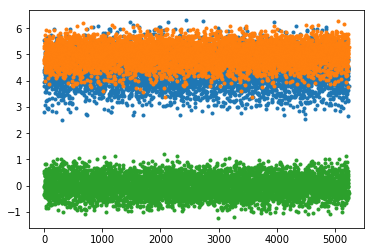

In [5]:
plot(nn.y_train,ls = '', marker = '.')

In [13]:
nn.nodes_per_layer = 16

In [14]:
nn.train(early_stopping=True, b=1e-8, restart = True)

--------Epoch = 0----------
Training loss || Validation loss
     4.205597 ||      4.191906
--------Epoch = 500----------
Training loss || Validation loss
     0.192606 ||      0.199343
--------Epoch = 1000----------
Training loss || Validation loss
     0.159648 ||      0.166874
--------Epoch = 1500----------
Training loss || Validation loss
     0.151362 ||      0.158837
--------Epoch = 2000----------
Training loss || Validation loss
     0.145770 ||      0.152989
--------Epoch = 2500----------
Training loss || Validation loss
     0.139279 ||      0.146683
--------Epoch = 3000----------
Training loss || Validation loss
     0.134475 ||      0.141928
--------Epoch = 3500----------
Training loss || Validation loss
     0.131506 ||      0.138857
--------Epoch = 4000----------
Training loss || Validation loss
     0.129754 ||      0.136988
--------Epoch = 4500----------
Training loss || Validation loss
     0.127883 ||      0.135332


======== Evaluation on test set =============
              RMSE =  0.1695
              MAE = 0.1317
              Max. abs. error = 1.6079


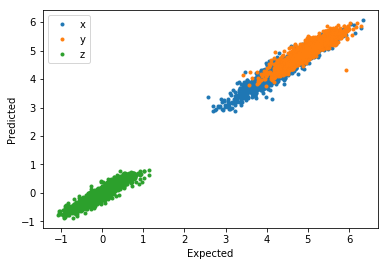

{'rmse': 0.16949185285460294,
 'mae': 0.13172735611150233,
 'max': 1.60788612269885}

In [7]:
nn.evaluate(plot=True, on='test')

======== Evaluation on test set =============
              RMSE =  0.1695
              MAE = 0.1317
              Max. abs. error = 1.6079


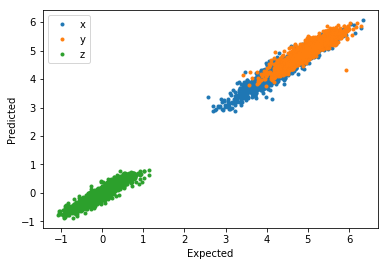

{'rmse': 0.16949185285460294,
 'mae': 0.13172735611150233,
 'max': 1.60788612269885}

In [8]:
nn.evaluate(plot=True, on='test')

In [6]:
ensemble = mlcf.ml.Ensemble_Network(nn)

In [10]:
ensemble.train_next()

Training model: 2
--------Epoch = 0----------
Training loss || Validation loss
     4.101655 ||      4.098485
--------Epoch = 500----------
Training loss || Validation loss
     0.391329 ||      0.403766
--------Epoch = 1000----------
Training loss || Validation loss
     0.242182 ||      0.262245
--------Epoch = 1500----------
Training loss || Validation loss
     0.191245 ||      0.210264
--------Epoch = 2000----------
Training loss || Validation loss
     0.180782 ||      0.197037
--------Epoch = 2500----------
Training loss || Validation loss
     0.174171 ||      0.188400
--------Epoch = 3000----------
Training loss || Validation loss
     0.169637 ||      0.182846
--------Epoch = 3500----------
Training loss || Validation loss
     0.167570 ||      0.180461
--------Epoch = 4000----------
Training loss || Validation loss
     0.166491 ||      0.179269


KeyboardInterrupt: 

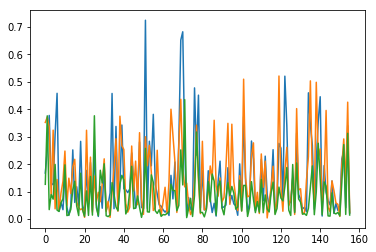

In [17]:
plot(ensemble.std_predict(nn.X_test, processed=True))

In [16]:
nn.save_all('../../elf_models/mlcf_master/16p16/pbesz_mbp_elf_long/')